<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/semana6/clase15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación binaria de imágenes 

Usaremos el conjunto de datos proporcionado por *Kaggle*, [*Dogs vs Cats*](https://www.kaggle.com/c/dogs-vs-cats/overview). 

**Objetivo**: Entrenar una red neuronal convolucional capaz de distinguir una imágen de un perro de la de un gato.

Esta clase esta basada en el [notebook](https://github.com/svishnu88/DLwithPyTorch/blob/master/Chapter5/ImageClassificationDogsandCats.ipynb) proporcionado por el libro *Deep Learning with Pytorch-Packt* de Vishnu Subramanian.



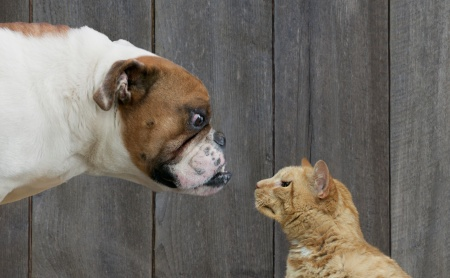



In [1]:
import torch 
import time
import matplotlib 
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')

# Revisar disponibilidad GPU

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


## Carga de datos

Descargamos el conjunto de datos siguiendo la siguiente guía: https://colab.research.google.com/github/lmoroney/mlday-tokyo/blob/master/Lab6-Cats-v-Dogs.ipynb#scrollTo=hwHXFhVG3786.

In [3]:
import os
import zipfile
import random
from shutil import copyfile

In [4]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-10-27 10:44:12--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.114.164.146, 2600:1407:3c00:10a2::e59, 2600:1407:3c00:108c::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.114.164.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   143MB/s    in 5.6s    

2021-10-27 10:44:18 (140 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [5]:
print('files on cats folder: {}'.format(len(os.listdir('/tmp/PetImages/Cat/'))))
print('files on dogs folder: {}'.format(len(os.listdir('/tmp/PetImages/Dog/'))))

# Expected Output:
# 12501
# 12501

files on cats folder: 12501
files on dogs folder: 12501


In [6]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [8]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [9]:
print('# de fotos de gato para entrenamiento:', len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print('# de fotos de perro para entrenamiento:', len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print('# de fotos de gato para prueba:', len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print('# de fotos de perro para prueba:', len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# de fotos de gato para entrenamiento: 11250
# de fotos de perro para entrenamiento: 11250
# de fotos de gato para prueba: 1250
# de fotos de perro para prueba: 1250


## Definición del conjunto de datos

Usaremos la clase `ImageFolder` del módulo `torchvison.datasets`. Esta clase funciona de forma similar a la clase `Dataset` de `torch.utils.data`, pues agrupa los elementos del conjunto de datos en una estructura iterable, la única diferencia es que el tipo de dato debe corresponder a una imagen. La clase `ImageFolder` recibe la dirección de la carpeta donde se encuentran las imágenes. Esta clase esta pensada para tareas de clasificación por lo que la carpeta deberá de tener un estructura especial, como la que se muestra a continuación: 

```
 mis-imágenes 
  +- categoría-0
  |  |
  |  +-- imagen1.jpg
  |  +-- imagen2.jpg
  |  ...
  +- categoría-1
  |  |
  |  +-- imagen3.jpg
  |  +-- imagen4.jpg
  |  ...
  +- categoría-2 
  |  |
  |  +-- imagen5.jpg
  |  +-- imagen6.jpg
  |  ...
  ...
```

En este caso `ImageFolder` le asignará a las imágenes en la subcarpeta `categoría-0` la etiqueta 0, a las que estan en `categoría-1` la etiqueta 1, etc. 

**Observación:** Si se quiere acceder al archivo `imagen5.jpg` la ruta es `mis-imágenes/categoría-2/imagen5.jpg`.

En nuestro caso tenemos la siguiente estructura:

```
tmp
 +- cats-v-dogs
    |
    +- training
    |
    |  +- cats
    |  +- dogs
    |
    +- testing
    |
    |  +- cats
    |  +- dogs
    |
```
por lo que será necesario hacer dos instancias de `ImageFolder` una para entrenamiento (training) y otra para validación (validation). Tanto la carpeta `training` como `testing` tienen subcarpetas `cats` y `dogs`, `ImageFolder` le asignará a cada imagen contenida en dichas subcarpetas la etiqueta 0 y 1, respectivamente.

También `ImageFolder` es capaz de transformar los elementos del conjunto de datos por medio del parámetro `transform`. En nuestro caso ajustaremos a las imágenes a un tamaño de $224 \times 224$ pixeles, convertiremos la imágenes a tensores y finalmente cada entrada la normalizaremos.

In [9]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [10]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train_set = ImageFolder('/tmp/cats-v-dogs/training/', transform=simple_transform)
val_set = ImageFolder('/tmp/cats-v-dogs/testing/', transform=simple_transform)

Verificamos la discretización de las clases.

In [12]:
print(train_set.class_to_idx)
print(train_set.classes)

{'cats': 0, 'dogs': 1}
['cats', 'dogs']


### Visualización de datos

In [11]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

class: cats


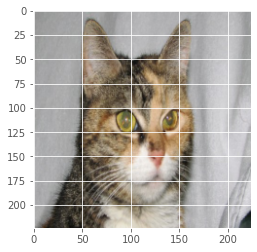

In [12]:
index = 10
imshow(train_set[index][0])
clase = train_set[index][1]
print('class: '+ train_set.classes[clase])

### Definición del DataLoader

In [13]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128, shuffle=True)

## Definición del modelo

In [14]:
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1) ## -> equivalente a aplicar nn.Flattern()
        ### termina Conv ###
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.sigmoid(x)

In [15]:
model = BinaryClassifier()
model = model.to(device)
print(model)

BinaryClassifier(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=56180, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


## Optimizador y función objetivo

In [16]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
criterion = nn.BCELoss()

## Entrenamiento

In [17]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    X = X.to(device) # Por si hay gpu
    Y = Y.to(device) # Por si hay gpu
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X).squeeze(1) # forward pass 
    loss = criterion(pred, Y.to(torch.float32)) # evaluación de predicción
    #import pdb; pdb.set_trace()
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    label = torch.as_tensor((pred - 0.5) > 0, dtype=torch.int32)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

In [18]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [21]:
epochs = 15
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(model, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 1/15 - train:   0%|          | 0/22498 [00:00<?, ?it/s, acc=0.0, avg_loss=0.0]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1/15 - train:  61%|██████▏   | 13824/22498 [01:42<01:04, 134.22it/s, acc=0.5276, avg_loss=0.6895]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping


 --- %s seconds --- 2565.7104625701904


### Evaluación

In [19]:
def show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))
  ax1.plot(epoch_acc, label='train')
  ax1.plot(val_acc, label='val')
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend()

  ax2.plot(epoch_loss, label='train')
  ax2.plot(val_loss, label='val')
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend()
  plt.show()

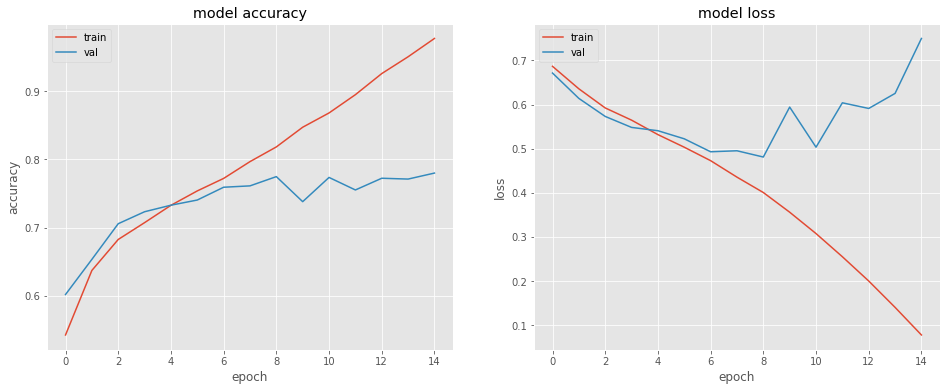

In [23]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

# Clasificación binaria de imágenes usando *transfer learning*

*Transfer learning* es la habilidad de usar un modelo ya entrenado para una tarea específica en otra tarea usando un conjunto de datos similar al que fue entrenado.

En esta sección veremos como reutilizar una red neural ya entrenada para hacer nuestra tarea de distinguir fotos de perros y gatos. 

Como ya hemos mencionado, la arquitectura de las CNN suele ser divida en dos partes, la primera corresponde a las capas convolucionales y la segunda a la parte completamente conectada. En las primeras capas de la primera parte es donde el modelo se concentra en razgos particulares como líneas y curvas. En las últimas capas distingue razgos de alto nivel de la imagen como ojos, dedos, etc. Debido a esta situación nos damos cuenta que no es necesario actualizar a todos los parámetros de la red sino que basta con modificar aquellos que esten cerca de la salida de la red. Más adelante aboradaremos este tema con más precisión.

Muchos algoritmos usados para reconocimiento de imágenes suelen ocupar modelos ya entrenados en la popular base de datos **ImageNet**, el reto de esta base de datos es distinguir fotos de 1,000 categorías. En este caso reciclaremos el modelo **VGG16** ya haremos modificaciones significativas a la parte completamente conectada.

El modelo **VGG16** lo podemos cargar desde ``torchvison.models``.

In [20]:
import torchvision.models as models

vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Observemos su arquitectura.

In [25]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Notamos que la arquitectura se divide en dos componentes: 

1. `features` que corresponde a la collección de capas convolucionales.
2. `classifier` que corresponde a la parte completamente conectada.

## Congelamiento de capas y *fine-tuning*

No queremos actualizar cada uno de los parámetros sobretodo la parte de `features` ya que al haber sido entrenada para reconocer rasgos significativos para imágenes en 1,000 categorías resultará útil para encontrar dichos rasgos de las imágenes de perros y gatos también. 

En este caso sólo entrenaremos una versión modificada del `classifier`.

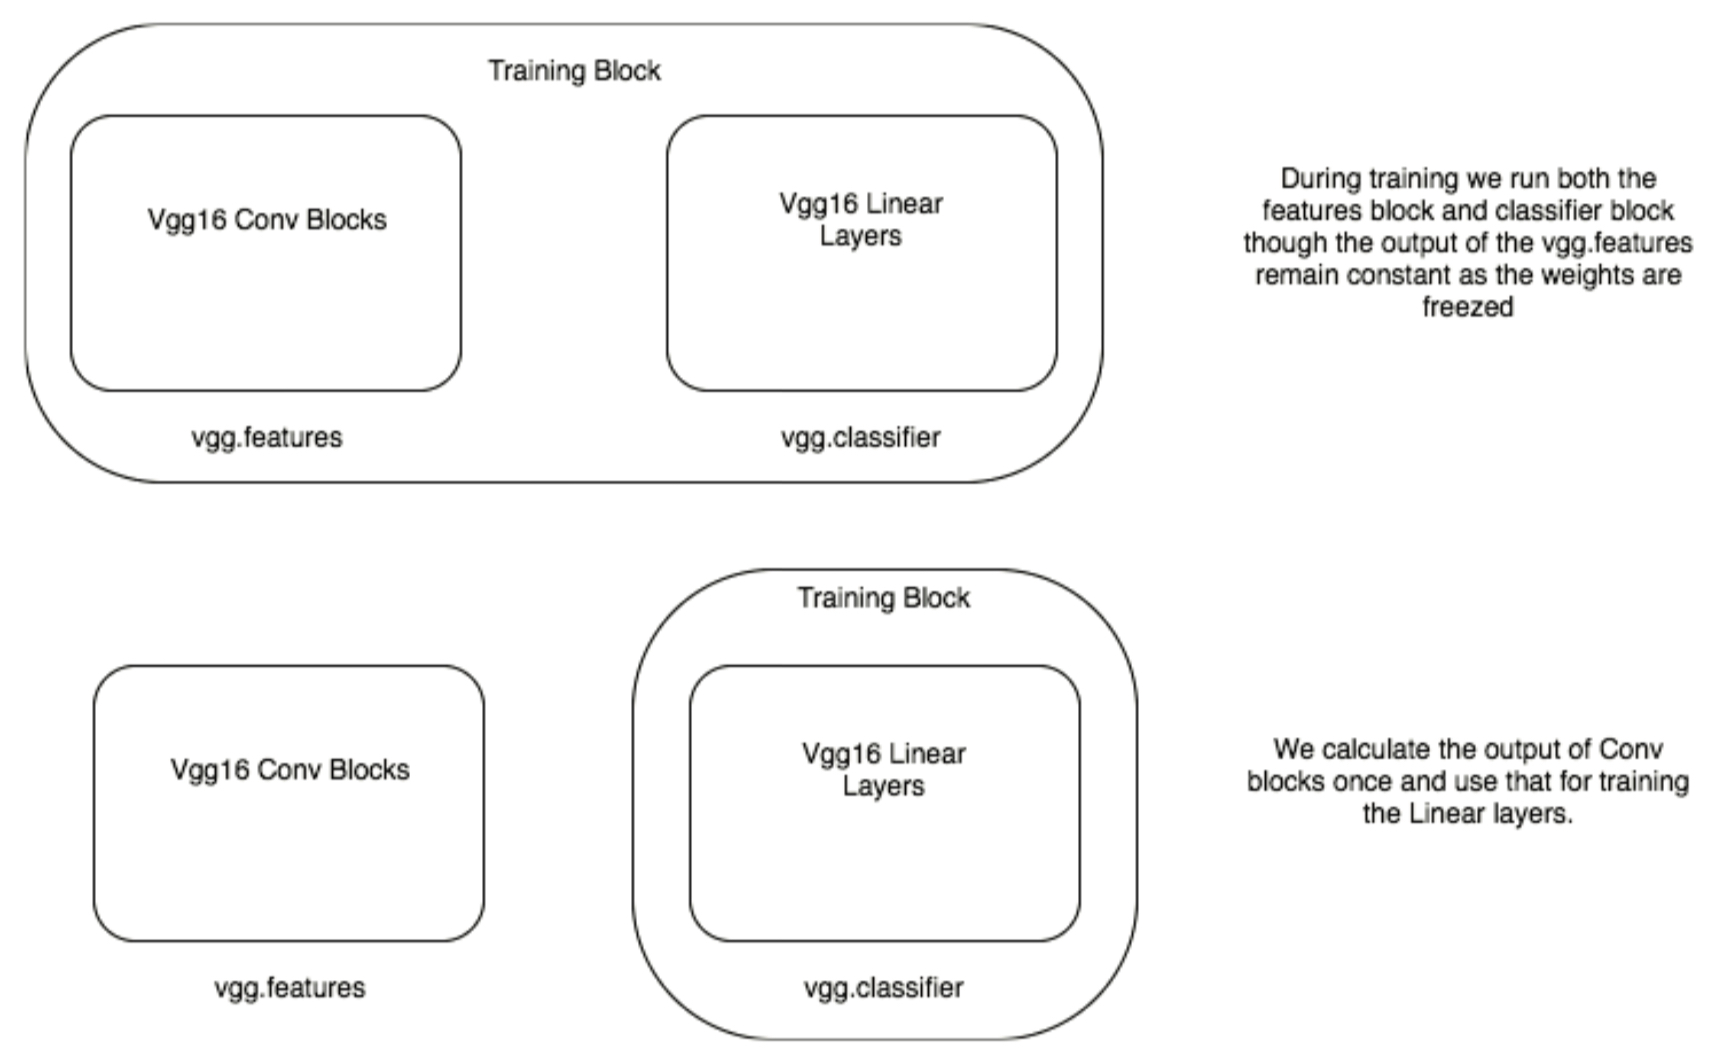

### *Fine-tuning*

El modelo VGG16 fue utilizado para clasificar imágenes en 1000 categorías, pero no fue entreando para distinguir perros de gatos, es por ello que es necesario redefinir la última capa, hay que pasar de 1000 salidas a 1 salida.

No sólo cambiaremos la capa de salida sino que redifiniremoes la arquitecura de `classifier` de la siguiente manera: 

In [21]:
vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

### Congelamiento de capas convolucionales

Con la siguiente instrucción aseguraremos que las capas convolucionales en `features` no sean entrendas:

In [22]:
for param in vgg.features.parameters(): param.requires_grad = False

if torch.cuda.is_available():
  vgg = vgg.cuda()

Observemos el resultado de aplicar estas dos operaciones:

In [28]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Optimizador

En este caso sólo le pasaremos al optimizador los parámetros de `classifier`.

In [23]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

## Entrenamiento de VGG16

In [24]:
epochs = 5
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 1/5 - train:   0%|          | 0/22498 [00:00<?, ?it/s, acc=0.0, avg_loss=0.0]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 1/5 - train:  48%|████▊     | 10752/22498 [02:38<02:52, 68.25it/s, acc=0.4787, avg_loss=0.6981]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size,


 --- %s seconds --- 1652.7386577129364


### Evaluación

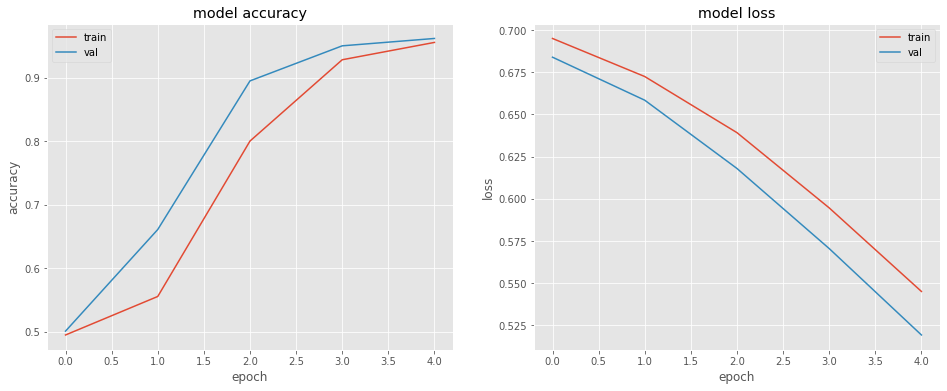

In [25]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

## Entrenamiento de VGG16 con ajuste de *Dropout*

Con las siguientes instrucciones podemos ajustar la propabilidad de aplicar *dropout* en las capas de `classifier`.

In [26]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [27]:
epochs = 3
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 1/3 - train:  37%|███▋      | 8320/22498 [02:01<03:27, 68.24it/s, acc=0.9339, avg_loss=0.5224]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/


 --- %s seconds --- 982.1930963993073


### Evaluación

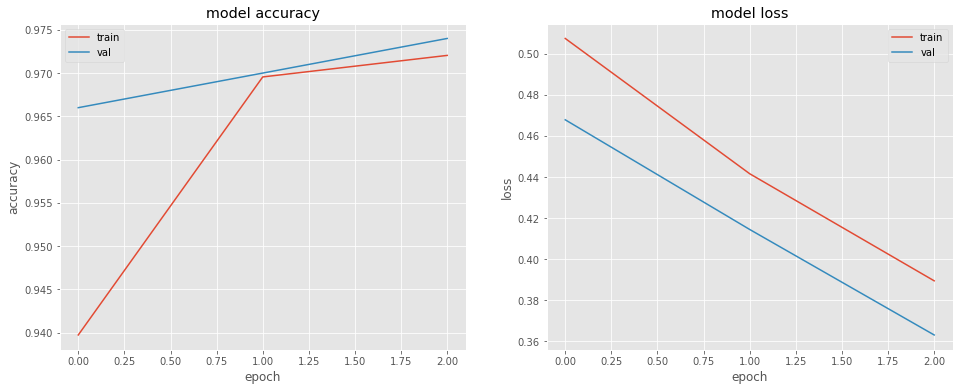

In [28]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

# Clasificación binaria de imágenes con *data augmentation*

En muchos casos no se tiene la cantidad suficiente de imágenes como para realizar un entrenamiento efectivo. Una forma de solventar ese problema es utilizando nuevos datos falsos o datos fabricados de los que ya se tienen. La técnica de *data augmentation* consiste en incrementar de manera artificial el numéro de imágenes del conjunto de datos. Un forma de conseguir dicho objetivo es aplicando transformaciones a las imágenes de forma aleatoria. En este caso usaremos transformaciones aleatorias que vienen en el módulo `torchvision.transforms`.


## Definición del conjunto de datos

In [29]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train_set = ImageFolder('/tmp/cats-v-dogs/training/', transform=train_transform)
val_set = ImageFolder('/tmp/cats-v-dogs/testing/', transform=simple_transform)

In [30]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)

### Visualización de imágenes modificadas

Observemos como aumentamos el tamaño del conjunto de datos de forma artificial.

class: cats


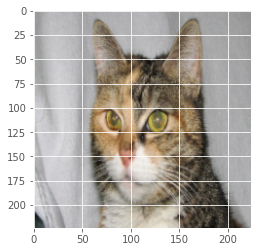

In [31]:
index = 10
imshow(train_set[index][0])
clase = train_set[index][1]
print('class: '+ train_set.classes[clase])

class: cats


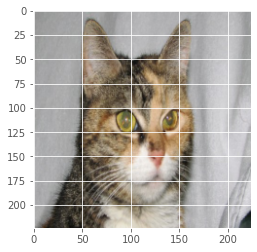

In [32]:
index = 10
imshow(train_set[index][0])
clase = train_set[index][1]
print('class: '+ train_set.classes[clase])

## Entrenamiento de VGG16 con *data augmentation*

In [33]:
epochs = 5
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 1/5 - train:  23%|██▎       | 5120/22498 [01:16<04:19, 66.90it/s, acc=0.9602, avg_loss=0.3776]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/


 --- %s seconds --- 1680.5951948165894


### Evaluación

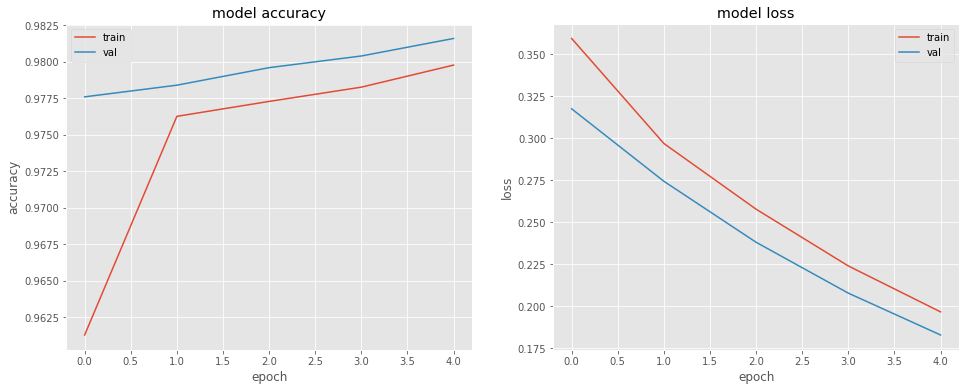

In [34]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

# ¿Qué aprenden las CNNs?

Para visualizar las salidas de las capas intermedias usaremos el método `register_forward_hook` que nos permitira extraer las salidas de una capa en particular sin su función de activación.

In [35]:
img, label = next(iter(train_loader))

In [36]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()

In [37]:
from torch.autograd import Variable 

conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

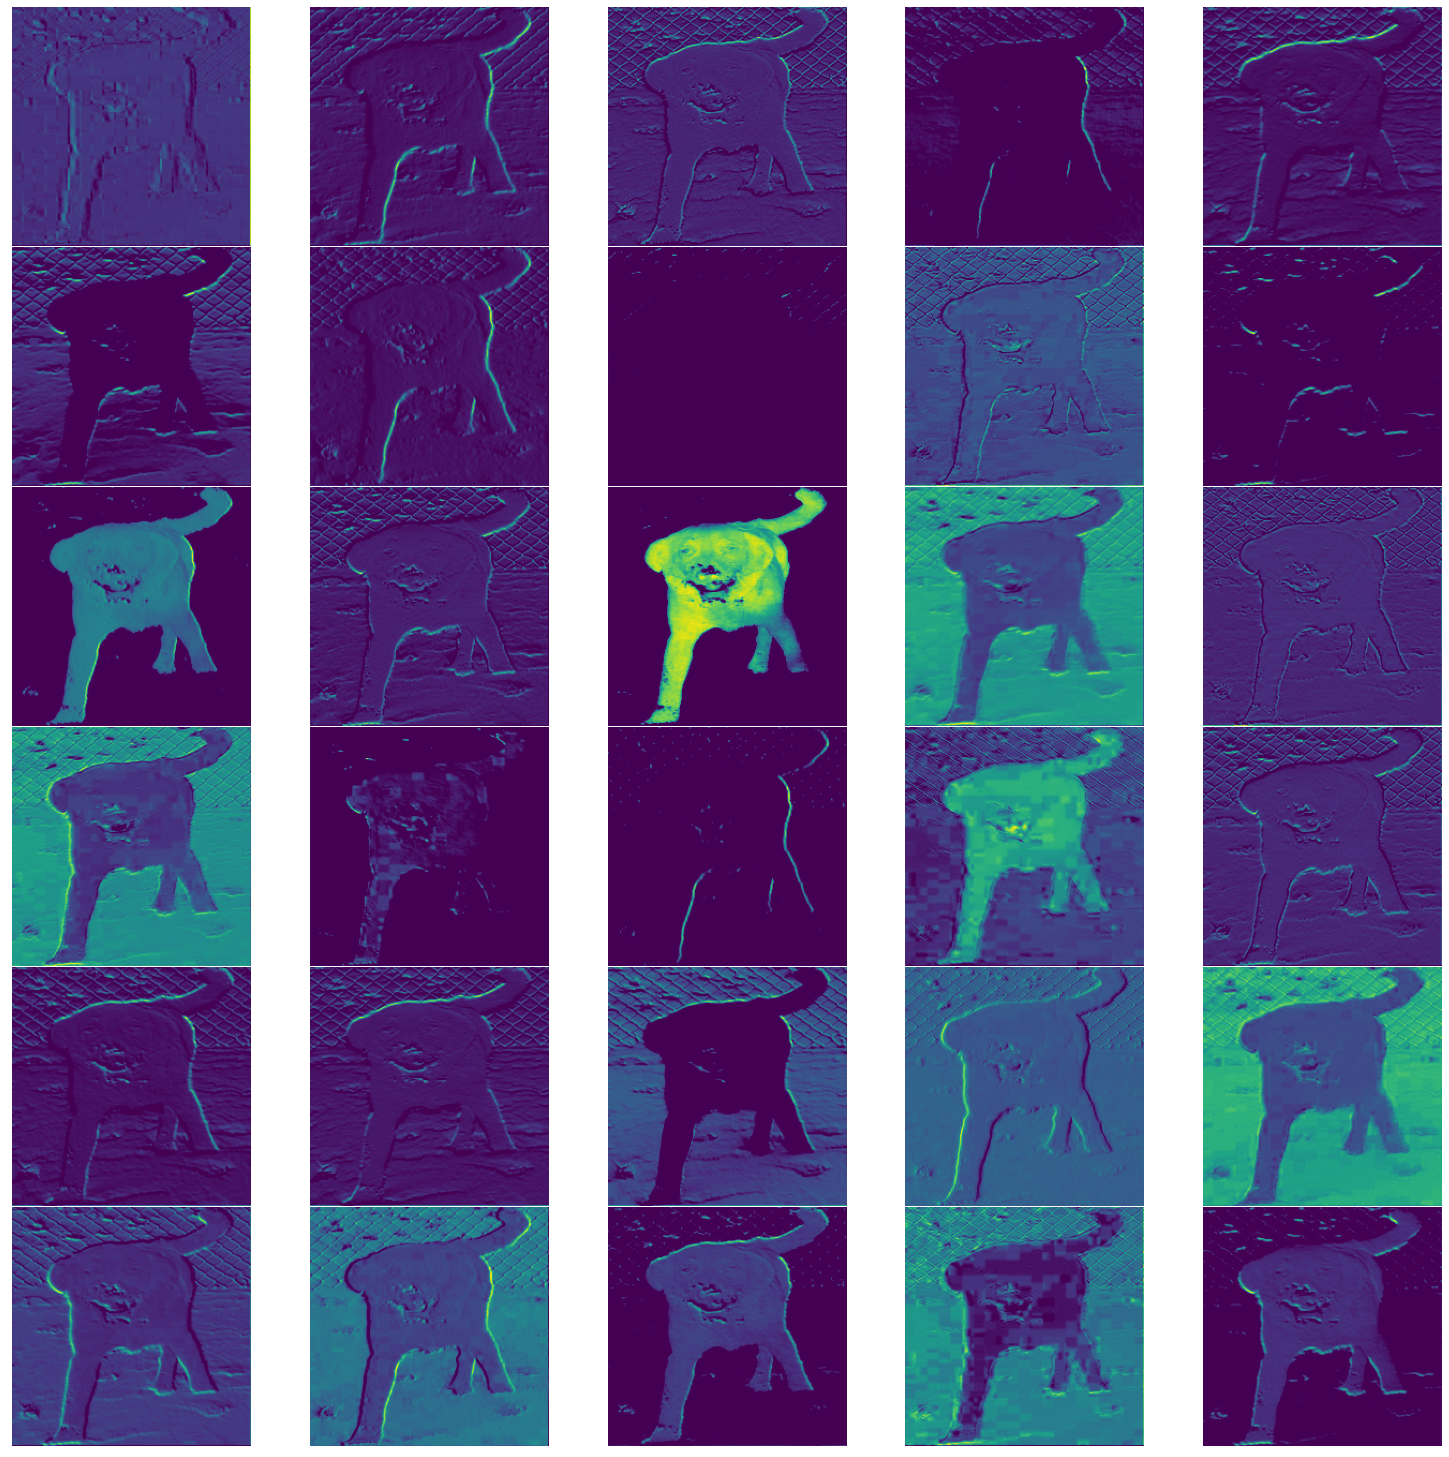

In [38]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

## Visualización de filtros

In [39]:
cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

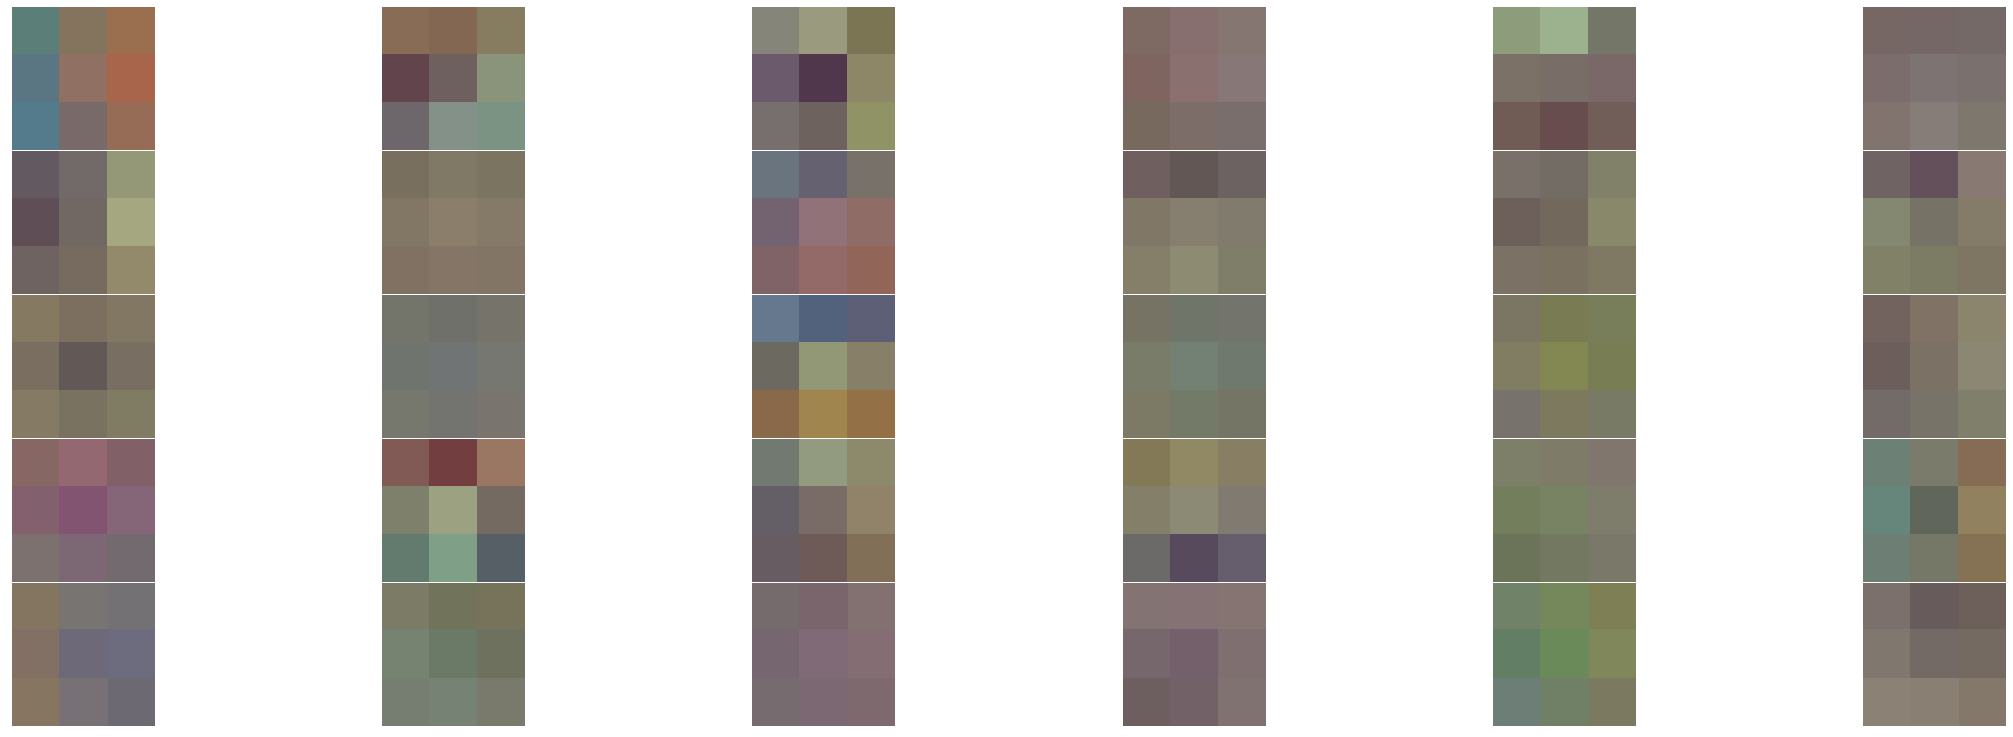

In [40]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])

## Guardar y cargar el modelo 

### Guardar en Drive 

In [41]:
*from google.colab import drive # Colab
drive.mount('/content/drive') # Colab

Mounted at /content/drive


In [43]:
PATH = '/content/drive/MyDrive/Classroom/Proyectos II Grupo 6034/models/vgg-dogs-vs-cats/'
torch.save(vgg.state_dict(), PATH + 'net')

### Cargar desde Drive

In [45]:
PATH = '/content/drive/MyDrive/Classroom/Proyectos II Grupo 6034/models/vgg-dogs-vs-cats/'
vgg.load_state_dict(torch.load(PATH + 'net'))
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## [Ejercicio] Prueba del modelo con mis propias imágenes

Para probar el modelo con una imagen propia, deberán de subir la imagen 

In [46]:
from PIL import Image

In [48]:
img = Image.open('/content/drive/MyDrive/Classroom/Proyectos II Grupo 6034/data-sets/dogs-vs-cats/dimitri1.JPG')

In [51]:
img_tensor = simple_transform(img)

In [53]:
batch_tensor = torch.unsqueeze(img_tensor, 0)

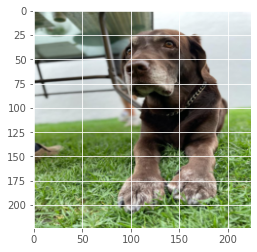

In [55]:
imshow(img_tensor)

In [61]:
out = vgg(batch_tensor.to(device))
prob = out.item()
print('La imagen con {:.2f} de probilidad es un perro'.format(prob))

La imagen con 0.87 de probilidad es un perro
